In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [2]:
file_path = '../input/fashion-data-cleaning/FashionData_Clean.csv'

In [3]:
df  = pd.read_csv(file_path, 
                  na_values = ['null', 'undefined', ''],
                 parse_dates = ['timestamp'])

In [4]:
print('Dataset has {} rows & {} columns'.format(*df.shape))
print('Column Names:', df.columns)

Dataset has 49984 rows & 16 columns
Column Names: Index(['timestamp', 'user_ID', 'ip_address', 'Product_Name', 'Product_ID',
       'Is_First_Order', 'User_Gender', 'Payment_Type', 'Number_of_Products',
       'Order_Coupon_Code', 'City', 'Country_Province', 'User_Birthday',
       'Country', 'Revenue', 'Order_Id'],
      dtype='object')


In [5]:
df.dtypes

timestamp             datetime64[ns]
user_ID                        int64
ip_address                    object
Product_Name                  object
Product_ID                    object
Is_First_Order               float64
User_Gender                   object
Payment_Type                  object
Number_of_Products            object
Order_Coupon_Code             object
City                          object
Country_Province              object
User_Birthday                 object
Country                       object
Revenue                      float64
Order_Id                       int64
dtype: object

In [6]:
df.isnull().sum()

timestamp                 0
user_ID                   0
ip_address                0
Product_Name              0
Product_ID                0
Is_First_Order            0
User_Gender            1174
Payment_Type              0
Number_of_Products        0
Order_Coupon_Code     38105
City                    337
Country_Province       4180
User_Birthday         27275
Country                   0
Revenue                   0
Order_Id                  0
dtype: int64

In [7]:
df = df.dropna(subset = ['Product_Name', 'Product_ID', 'Revenue']).reset_index(drop = 1)

In [8]:
split_cols = ['Product_Name', 'Product_ID', 'Number_of_Products']
df[split_cols] = df[split_cols].astype('string')

###

In [9]:
print('start date:', df['timestamp'].min(), '& end date:', df['timestamp'].max())
print('Thats 21 days (3 weeks) of customer order/purchase data')

start date: 2017-10-01 00:00:23 & end date: 2017-10-21 23:59:50
Thats 21 days (3 weeks) of customer order/purchase data


In [10]:
# total revenue from the store
print('Total Revenue for 3 weeks: {} AUD'.format(df['Revenue'].sum().round(2)))

# total products sold
num_sales = df['Number_of_Products'].str.split(',', expand = True).fillna('0').applymap(int).values.sum()
print('Total No.of Products sold (sales):', num_sales)

Total Revenue for 3 weeks: 6699843.72 AUD
Total No.of Products sold (sales): 101332


### 

In [11]:
# AVG revenue per order
revenue_per_order = (df['Revenue'].sum()/df['Product_ID'].count()).round(2)
print('Revenue per order : {} AUD , (Total valid orders = {})'.format(revenue_per_order, 
                                                                      df['Product_ID'].count()))

# unique products per order
unique_products_per_order = df['Product_ID'].str.split(',').map(set).map(len).mean()
print('AVG unique products per order : {}'.format(np.around(unique_products_per_order)))

Revenue per order : 134.04 AUD , (Total valid orders = 49984)
AVG unique products per order : 2.0


### group by
- Attributes - Time of Day, Day of Week, Geography, Payment Type.
- Frequency - How many are single/multiple purchasers? What is the frequency of multi-purchase? Any
typical attributes?

In [12]:
def split_and_count(df):
    return df.str.split(',').map(len).sum()

In [13]:
df['weekofday'] = df['timestamp'].dt.weekday
stats_by_dayofweek = df.groupby('weekofday').agg(revenue = ('Revenue', 'sum'), 
                                                 sales = ('Product_ID', split_and_count)).reset_index()

dayname_map = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

stats_by_dayofweek['weekofday'] = stats_by_dayofweek['weekofday'].replace(dayname_map)
stats_by_dayofweek

,weekofday,revenue,sales
0,Monday,1030982.29,14327
1,Tuesday,1193035.83,17786
2,Wednesday,1268237.32,19709
3,Thursday,1085146.10,16276
4,Friday,706237.58,10673
5,Saturday,603407.08,8479
6,Sunday,812797.52,11436


Text(0.5, 1.0, 'Revenue By Week of Day')

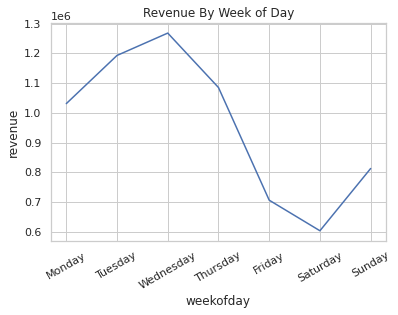

In [14]:
g = sns.lineplot(data=stats_by_dayofweek, x="weekofday", y="revenue",  sort=False)
plt.xticks(rotation=30)
plt.title('Revenue By Week of Day')

Text(0.5, 1.0, 'Revenue By Hour of Day')

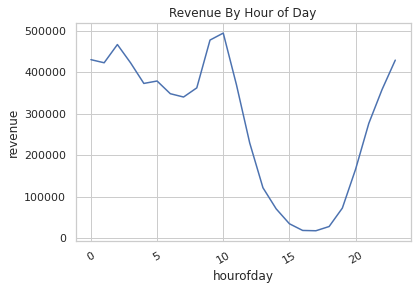

In [15]:
df['hourofday'] = df['timestamp'].dt.hour

stats_by_hourofday = df.groupby('hourofday').agg(revenue = ('Revenue', 'sum'), 
                                                 sales = ('Product_ID', split_and_count)).reset_index()
sns.lineplot(data=stats_by_hourofday, x="hourofday", y="revenue",  sort=False)
plt.xticks(rotation=30)
plt.title('Revenue By Hour of Day')

Text(0.5, 1.0, 'TOP 10 Cities majorly contributing to Revenue')

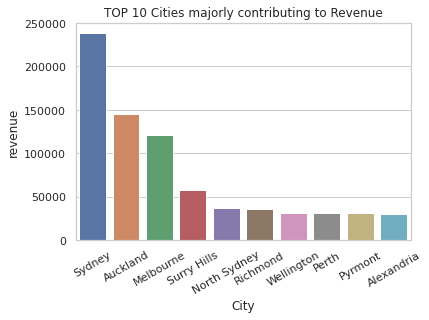

In [16]:
stats_by_city = df.groupby('City').agg(revenue = ('Revenue', 'sum'), 
                                       sales = ('Product_ID', split_and_count)).reset_index()
top10_cities = stats_by_city.sort_values(by = 'revenue', ascending = False).head(10)

sns.barplot(x = 'City', y='revenue', data = top10_cities)
plt.xticks(rotation=30)
plt.title('TOP 10 Cities majorly contributing to Revenue')

Text(0.5, 1.0, 'Revenue By Province')

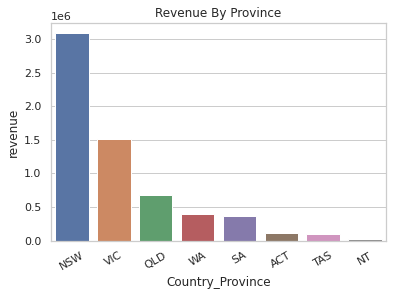

In [17]:
stats_by_province = df.groupby('Country_Province').agg(revenue = ('Revenue', 'sum'), 
                                       sales = ('Product_ID', split_and_count)).reset_index()

stats_by_province = stats_by_province.sort_values(by = 'revenue', ascending = False)

sns.barplot(x = 'Country_Province', y='revenue', data = stats_by_province)
plt.xticks(rotation=30)
plt.title('Revenue By Province')

Text(0.5, 1.0, 'Revenue By Payment Types')

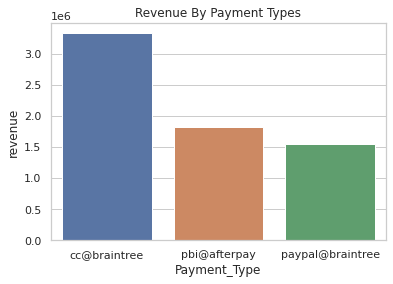

In [18]:
stats_by_paymentype = df.groupby('Payment_Type').agg(revenue = ('Revenue', 'sum'), 
                                       sales = ('Product_ID', split_and_count)).reset_index()
stats_by_paymentype = stats_by_paymentype.sort_values(by = 'revenue', ascending = False).head(3)
sns.barplot(x = 'Payment_Type', y='revenue', data = stats_by_paymentype)
plt.title('Revenue By Payment Types')

In [19]:
user_order_counts = df.groupby(['user_ID']).agg(num_orders = ('user_ID', 'count')).reset_index()

single_order_users = len(user_order_counts[user_order_counts['num_orders'] == 1])
multiple_order_users = len(user_order_counts[user_order_counts['num_orders'] > 1])

print('users who only ordered once: {} -> {:.2f}%'.format(single_order_users, 
                                                        single_order_users*100/len(user_order_counts)))
print('user with more than one order: {} -> {:.2f}%'.format(multiple_order_users, 
                                                        multiple_order_users*100/len(user_order_counts)))

users who only ordered once: 39778 -> 90.22%
user with more than one order: 4311 -> 9.78%


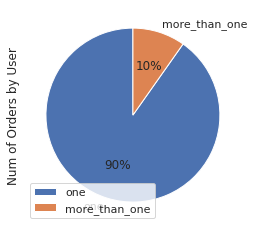

In [20]:
users_df = pd.Series({'one':single_order_users, 
                       'more_than_one': multiple_order_users},
                     name = 'Num of Orders by User')
ax = users_df.plot(kind='pie', autopct='%1.f%%', startangle=90, legend = True)

In [21]:
single_item_orders = len(df[df['Product_ID'].str.split(',').map(len) == 1])
multiple_item_orders = len(df[df['Product_ID'].str.split(',').map(len) > 1])
print('orders with only single item: {} -> {:.2f}%'.format(single_item_orders, 
                                                          single_item_orders*100/len(df)))
print('orders with more than one item: {} -> {:.2f}%'.format(multiple_item_orders, 
                                                            multiple_item_orders*100/len(df)))

orders with only single item: 26284 -> 52.58%
orders with more than one item: 23700 -> 47.42%


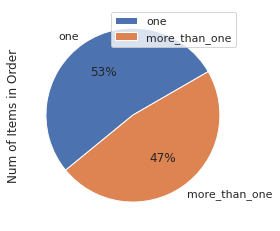

In [22]:
orders_df = pd.Series({'one':single_item_orders, 
                       'more_than_one': multiple_item_orders},
                     name = 'Num of Items in Order')
ax = orders_df.plot(kind='pie', autopct='%1.f%%', startangle=30, legend = True)

### Product Affinity

In [23]:
# prod_id_names_map = {}
# for pid_str, pns_str in zip(df['Product_ID'].tolist(), df['Product_Name'].tolist()):
#     pids = pid_str.split(',')
#     pns = pns_str.split(',')
#     for pid, pn in zip(pids, pns):
#         prod_id_names_map[pid] = pn
        
# len(prod_id_names_map)

# THERE ARE MANY DUPLICATE PRODUCT NAMES (needs texts preprocessing) - can't relay on IDs.

In [24]:
df_affinity = df[['user_ID', 'Order_Id', 'Product_Name']].copy()
df_affinity = df_affinity.apply(lambda x: x.str.split(',') if x.name in split_cols else x)
df_affinity.head()

,user_ID,Order_Id,Product_Name
0,0,1,[Kendrick]
1,0,2,[Smartwatch Bradshaw Gold]
2,0,3,[Classic Slides]
3,0,4,[Bonaire Flared Sleeve Tunic]
4,0,5,[Tall Tales Man Style Pants]


In [25]:
import re
pattern = re.compile('[^a-zA-Z0-9\s]+')

def clean_product_names(list_str):
    replaced_str = [pattern.sub(string = s, repl = ' ') for s in list_str]
    return ['_'.join(s.lower().split(' ')) for s in replaced_str]


df_affinity['Product_Name'] = df_affinity['Product_Name'] .apply(clean_product_names)

In [26]:
# there are over 20K unique products & 100K sales.
# consider only order having atleast 3 purchases.
# doing this to eliminate noise. otherwise it will be difficult get any good patterns.
dfa_sample = df_affinity[df_affinity['Product_Name'].str.len() > 3]
print('No.of Orders with atleast 4 purchases:', len(dfa_sample))

No.of Orders with atleast 4 purchases: 5745


In [27]:
dfa_list = dfa_sample['Product_Name'].tolist()
len(dfa_list)

5745

In [28]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
te = TransactionEncoder()
te_ary = te.fit(dfa_list).transform(dfa_list)
dfa = pd.DataFrame(te_ary, columns=te.columns_)
dfa.shape

(5745, 11419)

In [29]:
# frequent_itemsets = apriori(dfa, min_support=0.001, use_colnames=True)
# frequent_itemsets = fpmax(dfa, min_support=0.01, use_colnames=True)
frequent_itemsets = fpgrowth(dfa, min_support=0.001, use_colnames=True)
print(frequent_itemsets.shape)
frequent_itemsets.tail()

(1129, 2)


,support,itemsets
1124,0.001218,"(havaianas_slim___women_s, havaianas_slim_logo..."
1125,0.002089,"(modern_cotton_thong, modern_cotton_bralette)"
1126,0.001044,"(staple_crew_tee, staple_shorts)"
1127,0.001915,"(dominica_high_waisted_briefs, belilze_balcone..."
1128,0.001218,"(maui_rib_bikini_briefs, maui_rib_top)"


In [30]:
from mlxtend.frequent_patterns import association_rules
asr_df = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.25)
asr_df.shape

(17, 9)

In [31]:
asr_df.sort_values(by=  'confidence', ascending =False, inplace = True)
# asr_df[['antecedents', 'consequents']]

In [32]:
affine_prods = set()
for a, c in zip(asr_df['antecedents'].tolist(), asr_df['consequents'].tolist()):
    affine_prods.add(a.union(c))

In [33]:
pd.DataFrame([list(fs) for fs in list(affine_prods)])

,0,1
0,customised_stretch_bralette,bikini
1,modern_cotton_bikini_briefs,modern_cotton_bralette
2,modern_cotton_thong,modern_cotton_bralette
3,havaianas_slim___women_s,havaianas_slim_logo_pop_up___women_s
4,basic_3_4_tights,essentials_linear_slim_tank
5,hayman_shorts,staple_shorts
6,vapor_cotton_tee,champion_jersey_shorts
7,belilze_balconette_bikini_top,dominica_high_waisted_briefs
8,good_vibes_tee,world_tee
9,heritage_tights,heritage_classic_tee___unisex
